# Modal Asurance Criterion Analysis

### Modules

In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Get modal data

The following image shows the FEM node for each corresponding experimental point.

<div align = center>
    <img width = 200 src = attachment:bcbf75d2-88a5-42fb-bc01-1eb0dbb80e26.png />
<div\>
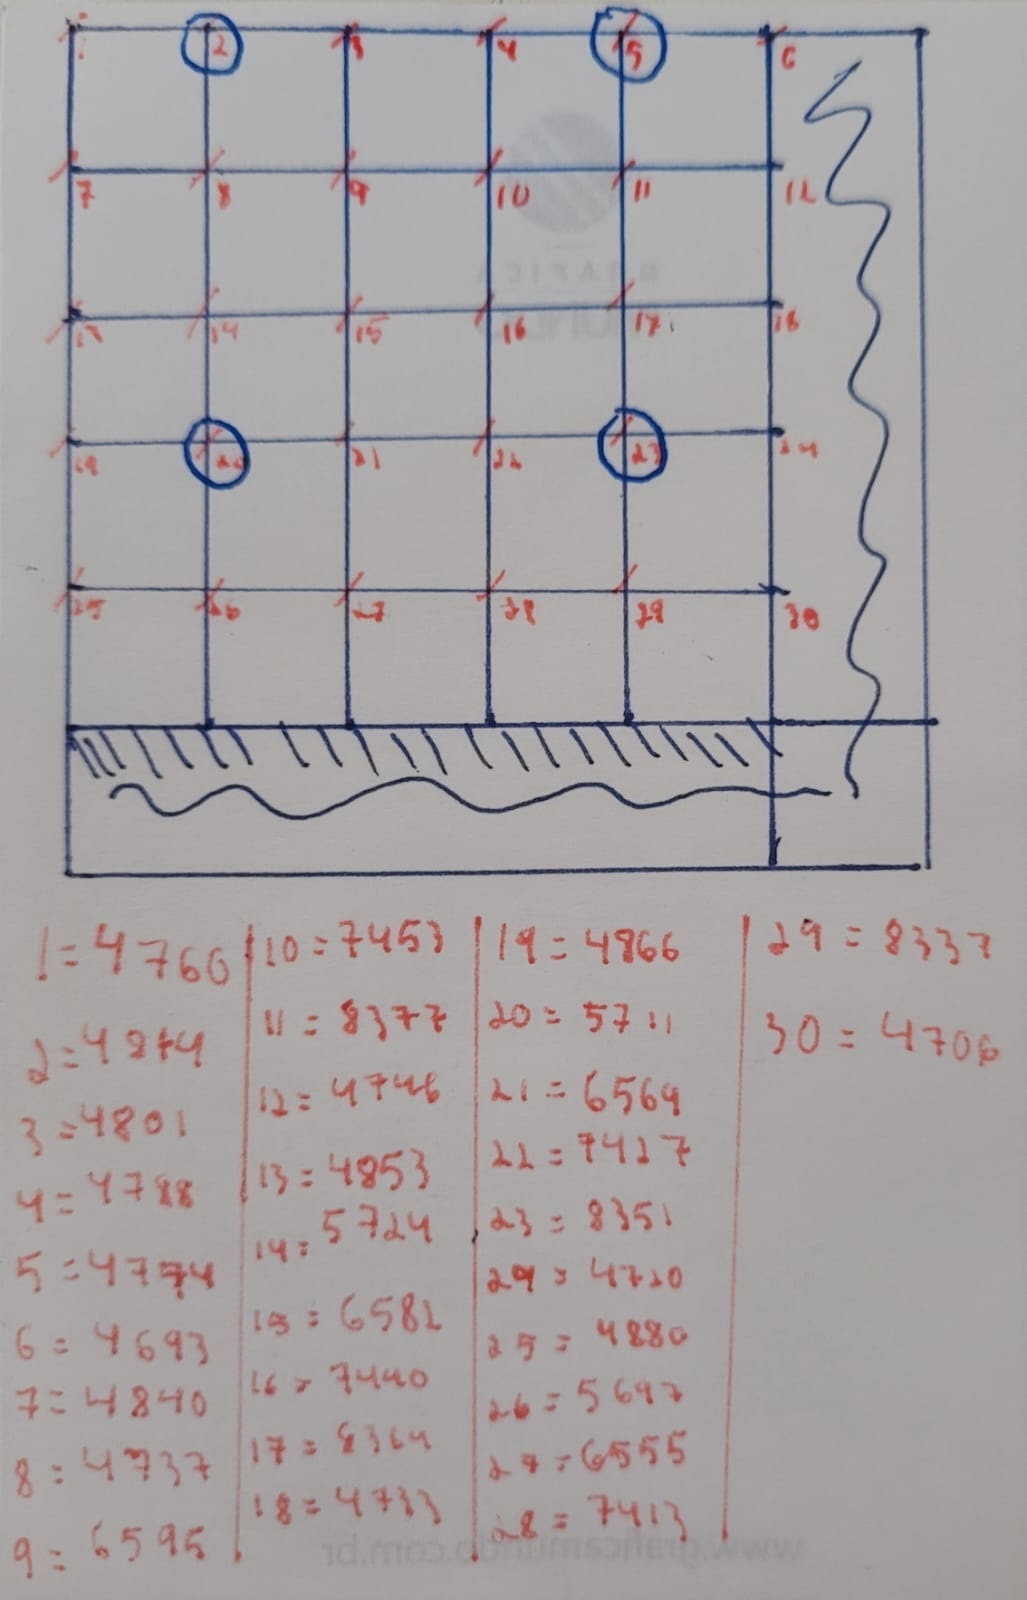

Getting modal data from FEM results. `fem_mode(mode)` reads the imaginary value from the FRF for each mode (1 to 7) and each node (corresponding to experimental point).

In [2]:
files = os.listdir()
mode = 1
for i in range(len(files)):
    if 'txt' in files[i] and 'freq' not in files[i]:
        data = pd.read_csv(files[i], header = 0, sep = r"\s+", index_col = 0)
        data.to_csv(f'Mode{mode}.csv')
        mode += 1        

In [3]:
def fem_mode(mode):
    mode = pd.read_csv(f'Mode{mode}.csv')
    mode_i = mode.drop(['Node', 'Num', 'X', 'Y', 'Z', 'UX', 'UZ'], axis = 1)
    
    nodes = np.array([123, 172, 160, 147, 135, 63, 
                      195, 939, 1647, 2414, 3122, 111,
                      207, 927, 1635, 2402, 3110, 99,
                      219, 915, 1623, 2390, 3098, 87,
                      231, 903, 1611, 2319, 3086, 75 ])
    

    nodes -= 1 
    mode_i = mode_i.iloc[nodes].to_numpy()
    return mode_i

In [4]:
modes_to_get = 5

fem_m = np.array([fem_mode(i+1) for i in range(modes_to_get)])

Get the experimental data

In [5]:
owd = os.getcwd()
os.chdir("../..")
path = os.path.join(os.getcwd(), "7 - Experimental/placa sem dano/novos")
os.chdir(path)

In [6]:
data_list = []

for file in os.listdir():
    if 'Im' in file:
        data = pd.read_excel(file, header = 2)
        data_list.append(data)

In [7]:
dfs = [df.set_index('X Value') for df in data_list]
nodes = [i+1 for i in range(30)]
dfs = pd.concat(dfs, axis=1, names=nodes)
dfs.set_axis(nodes, axis=1, inplace=True)

In [8]:
wn = [256 , 488, 1216, 1512] # resultados ensaio
wn = [256 , 488, 1180, 1488, 1568]   resultados ensaio
#wn = [268, 500, 1092, 1432] # reusltados ansys

dfs.loc[wn]

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
X Value,,,,,,,,,,,,,,,,,,,,,
256,0.355354,0.388307,0.413222,0.344163,0.336573,-0.299525,0.310152,0.368569,0.284935,0.270028,...,0.126102,0.162806,0.121278,0.120318,0.057331,0.050368,0.053548,0.054996,0.077921,0.047027
488,0.749592,0.489629,0.127752,-0.226240,-0.588892,0.721102,0.667343,0.476870,0.105089,-0.150500,...,0.059687,-0.091095,-0.202721,-0.341276,0.180016,0.082586,0.024536,-0.036761,-0.127398,-0.141947
1180,0.045561,0.043508,0.043500,0.040057,0.050696,-0.060652,0.016657,0.015642,0.002860,0.003232,...,-0.035746,-0.052218,-0.047273,-0.054843,-0.021930,-0.020068,-0.023382,-0.029769,-0.044142,-0.033061
1488,0.186264,0.146234,0.063306,-0.049687,-0.146347,0.178312,0.061410,0.065825,0.022784,-0.009965,...,-0.035676,0.040486,0.091444,0.144369,-0.142646,-0.070899,-0.023341,0.028988,0.085497,0.096206
1568,-0.100337,-0.034278,0.039419,0.058158,0.034751,0.006225,-0.061735,-0.027145,0.022282,0.033914,...,0.017056,0.001393,-0.027869,-0.057523,0.024128,0.015525,0.009289,-0.005372,-0.028399,-0.036683


In [9]:
exp_m = np.array([dfs.loc[i].to_numpy().reshape([30, 1]) for i in wn])

## MAC

<div align = center>
    <img width = 500 src= attachment:9a13d638-629b-4c87-8977-a3bcdb1c3be0.png \>
<div\>

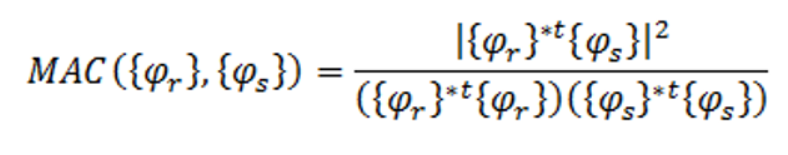

In [10]:
def mac_rs(r,s):
    
    mac = abs(np.dot(r.T, s))**2 / np.dot(np.dot(r.T, r), np.dot(s.T, s)) # Calcula o valor de mac para cada elemento da matriz
    
    return float(mac)

In [14]:
def mac_matrix(a, b):
    
    mac = []
    for i in a:
        for j in b:
            m = mac_rs(i,j)
            mac.append(m)

    mac = np.array(mac)
    mac = mac.reshape(5, 5)
    
    return mac

Getting the MAC matrix for exp-exp and FEM-FEM for validation and than for exp-fem for analysis.

In [15]:
exp_m.shape

(5, 30, 1)

In [19]:
mac_exp_exp = mac_matrix(exp_m, exp_m)
mac_fem_fem = mac_matrix(fem_m, fem_m)
mac_exp_fem = mac_matrix(exp_m, fem_m)

Plotting the results using `sns.heatmap()`

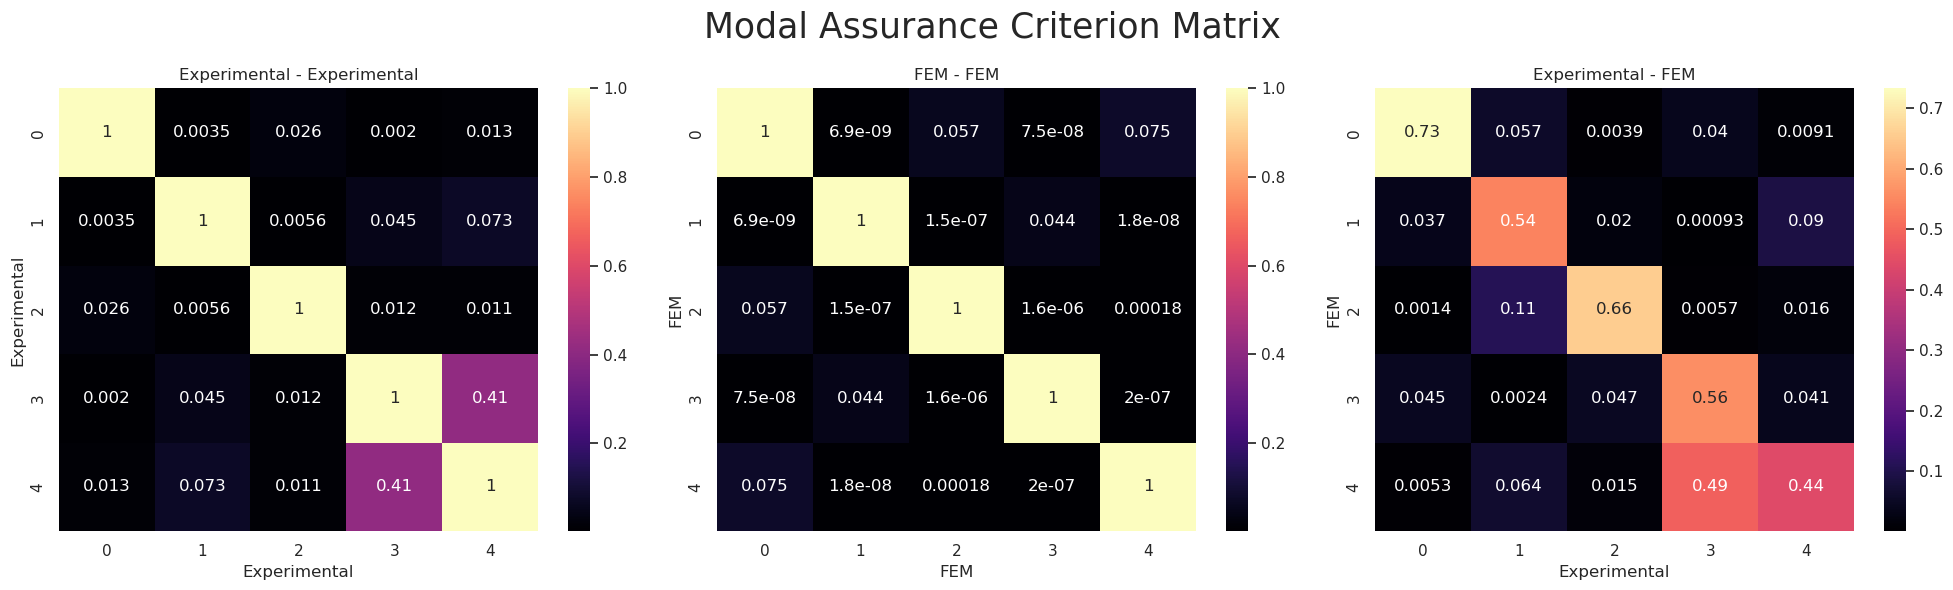

In [20]:
sns.set(rc={'figure.figsize':(10,7), 'font.size': 12})

fig, ax = plt.subplots(1,3, figsize = (20, 6), dpi = 100)

fig.suptitle('Modal Assurance Criterion Matrix', fontsize = 25)

sns.heatmap(mac_exp_exp, cmap='magma', annot=True, ax=ax[0],)
ax[0].set(title = 'Experimental - Experimental', xlabel = 'Experimental' , ylabel = 'Experimental')

sns.heatmap(mac_fem_fem, cmap='magma', annot=True, ax=ax[1],)
ax[1].set(title = 'FEM - FEM', xlabel = 'FEM' , ylabel = 'FEM')

sns.heatmap(mac_exp_fem, cmap='magma', annot=True, ax=ax[2],)
ax[2].set(title = 'Experimental - FEM', xlabel = 'Experimental' , ylabel = 'FEM')

fig.tight_layout()

In [23]:
fig.savefig('MAC.jpg', dpi = 500)

In [22]:
os.chdir(owd)